In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import septum_mec.analysis.data_processing as dp
from septum_mec.analysis.registration import store_notebook
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import quantities as pq
import exdir
from distutils.dir_util import copy_tree
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
from septum_mec.analysis.trackunitmulticomparison import TrackMultipleSessions
import networkx as nx
from nxpd import draw
%matplotlib inline

12:42:00 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
project_path = dp.project_path()

project = expipe.get_project(project_path)
actions = project.actions

In [4]:
output = pathlib.Path('output/identify_neurons')
output.mkdir(parents=True, exist_ok=True)

In [5]:
identify_neurons = project.require_action('identify-neurons')

In [6]:
actions['1833-010719-2'].attributes

{'users': ['Mikkel Lepperød'],
 'tags': ['11hz', 'stim-ms', 'stim i', 'septum', 'open-ephys'],
 'datetime': '2019-07-01T12:54:49',
 'type': 'Recording',
 'registered': '2019-07-02T14:53:28',
 'data': {'main': 'main.exdir'},
 'location': 'IMB',
 'entities': ['1833']}

In [7]:
data_loader = dp.Data()

In [33]:
skip_actions = [
    '1849-270219-1', 
    '1849-260219-2', 
    '1834-250219-1',
    '1834-230219-1',
    '1833-050619-4'
]

In [83]:
sessions = []
for action in actions.values():
    if action.id in skip_actions:
        continue
    if action.type != 'Recording':
        continue
    action_data_path = pathlib.Path(action.data_path('main'))
    processing = exdir.File(action_data_path)['processing']

    if not 'electrophysiology' in processing:
        continue
    elphys = processing['electrophysiology']
    if 'spikesorting' not in elphys:
        continue
    tags = [t.lower() for t in action.tags]
    
    freq = np.nan
    stimulated = False
    baseline = False
    is_i = False
    is_ii = False
    tag = None
    stim_location = None
    
    stim_times = data_loader.stim_times(action.id)
    if stim_times is not None:
        stimulated = True
        freq = round(1 / np.median(np.diff(stim_times)))
        
    
    
    tag_i = [i for i, t in enumerate(tags) if 'baseline ' in t or 'stim ' in t]
    if len(tag_i) == 1:
        tag = tags[tag_i[0]]
        what, how = tag.split(' ')
        if what == 'stim':
            where = [t for t in tags if 'stim-' in t]
            assert len(where) == 1
            stim_location = where[0].split('-')[-1]
            assert stimulated
        elif what == 'baseline':
            baseline = True
            assert not stimulated
        else:
            raise Exception(f'Found {tag}, what to do?')
        if how == 'i':
            is_i = True
        elif how == 'ii':
            is_ii = True
        else:
            raise Exception(f'Found {tag}, what to do?')
    elif len(tag_i) > 1:
        print(action.id, [tags[i] for i in tag_i])
        
    

    sessions.append({
        'tag': tag,
        'action': action.id,
        'stimulated': stimulated,
        'baseline': baseline,
        'i': is_i,
        'ii': is_ii,
        'frequency': float(freq),
        'session': int(action.id.split('-')[-1]),
        'stim_location': stim_location,
        'entity': int(action.entities[0]),

    })
sessions = pd.DataFrame(sessions)

In [84]:
sessions.query('stimulated and frequency!=30')

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag
3,1839-060619-3,False,1839,11.0,True,False,3,ms,True,stim i
7,1849-110319-2,False,1849,11.0,True,False,2,ms,True,stim i
9,1834-220319-2,False,1834,11.0,True,False,2,ms,True,stim i
12,1834-120319-2,False,1834,11.0,True,False,2,ms,True,stim i
19,1833-260619-2,False,1833,11.0,True,False,2,ms,True,stim i
20,1849-010319-4,False,1849,11.0,True,False,4,mecr,True,stim i
23,1849-220319-3,False,1849,11.0,True,False,3,ms,True,stim i
28,1834-150319-2,False,1834,11.0,True,False,2,ms,True,stim i
30,1839-290519-2,False,1839,11.0,True,False,2,ms,True,stim i
37,1849-150319-2,False,1849,11.0,True,False,2,ms,True,stim i


In [85]:
sessions['date'] = sessions.apply(lambda x: x.action.split('-')[1], axis=1)
sessions['entity_date'] = sessions.apply(lambda x: '-'.join(x.action.split('-')[:2]), axis=1)

In [86]:
sessions['Hz11'] = sessions.frequency==11
sessions['Hz30'] = sessions.frequency==30

In [87]:
for entity_date, day in sessions.groupby('entity_date'):
    day = day.sort_values('session')
    for (_,now), (_,after) in zip(day.iterrows(), day.iloc[1:,:].iterrows()):
        if after.frequency == 11:
            if now.baseline:
#                 print(now.name)
                sessions.loc[now.name, 'Hz11'] = True
        if after.frequency == 30:
            if now.baseline:
                sessions.loc[now.name, 'Hz30'] = True

In [93]:
sessions.query('baseline and not Hz11 and not Hz30')

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,date,entity_date,Hz11,Hz30
27,1833-050619-3,True,1833,NaN,False,True,3,None,False,baseline ii,050619,1833-050619,False,False
29,1849-110319-3,True,1849,NaN,False,True,3,None,False,baseline ii,110319,1849-110319,False,False
48,1839-290519-3,True,1839,NaN,False,True,3,None,False,baseline ii,290519,1839-290519,False,False


In [95]:
sessions.to_csv(output / 'sessions.csv', index=False)

In [37]:
all_non_identified_units = []
for action in sessions.action.values:
    for ch in range(8):
        for unit_name in data_loader.unit_names(action, ch):
            all_non_identified_units.append({
                'unit_name': unit_name, 
                'action': action, 
                'channel_group': ch
            })
all_non_identified_units = pd.DataFrame(all_non_identified_units)

In [38]:
all_non_identified_units.to_csv(output / 'all_non_identified_units.csv', index=False)

# Identify unique neurons

In [12]:
# save graphs
for entity, values in sessions.groupby('entity'):
    data_path = output / f'{entity}-graphs'
    if data_path.exists():
        continue
    print('Processing', entity)
    unit_matching = TrackMultipleSessions(
        actions, values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.do_matching()
    unit_matching.make_graphs_from_matches()
    unit_matching.compute_time_delta_edges()
    unit_matching.compute_depth_delta_edges()
    # save graph with all dissimilarities for later use
    unit_matching.save_graphs()

Processing 1833



Processing 1834



Processing 1839



Processing 1849


# Plot comparisons

In [13]:
unit_comp = TrackMultipleSessions(actions, data_path=f'output/identify_neurons/1833-graphs')

In [14]:
unit_comp.load_graphs()

In [15]:
max_dissimilarity = .05
max_depth_delta = 100

unit_comp.remove_edges_above_threshold('weight', max_dissimilarity)
unit_comp.remove_edges_above_threshold('depth_delta', max_depth_delta)

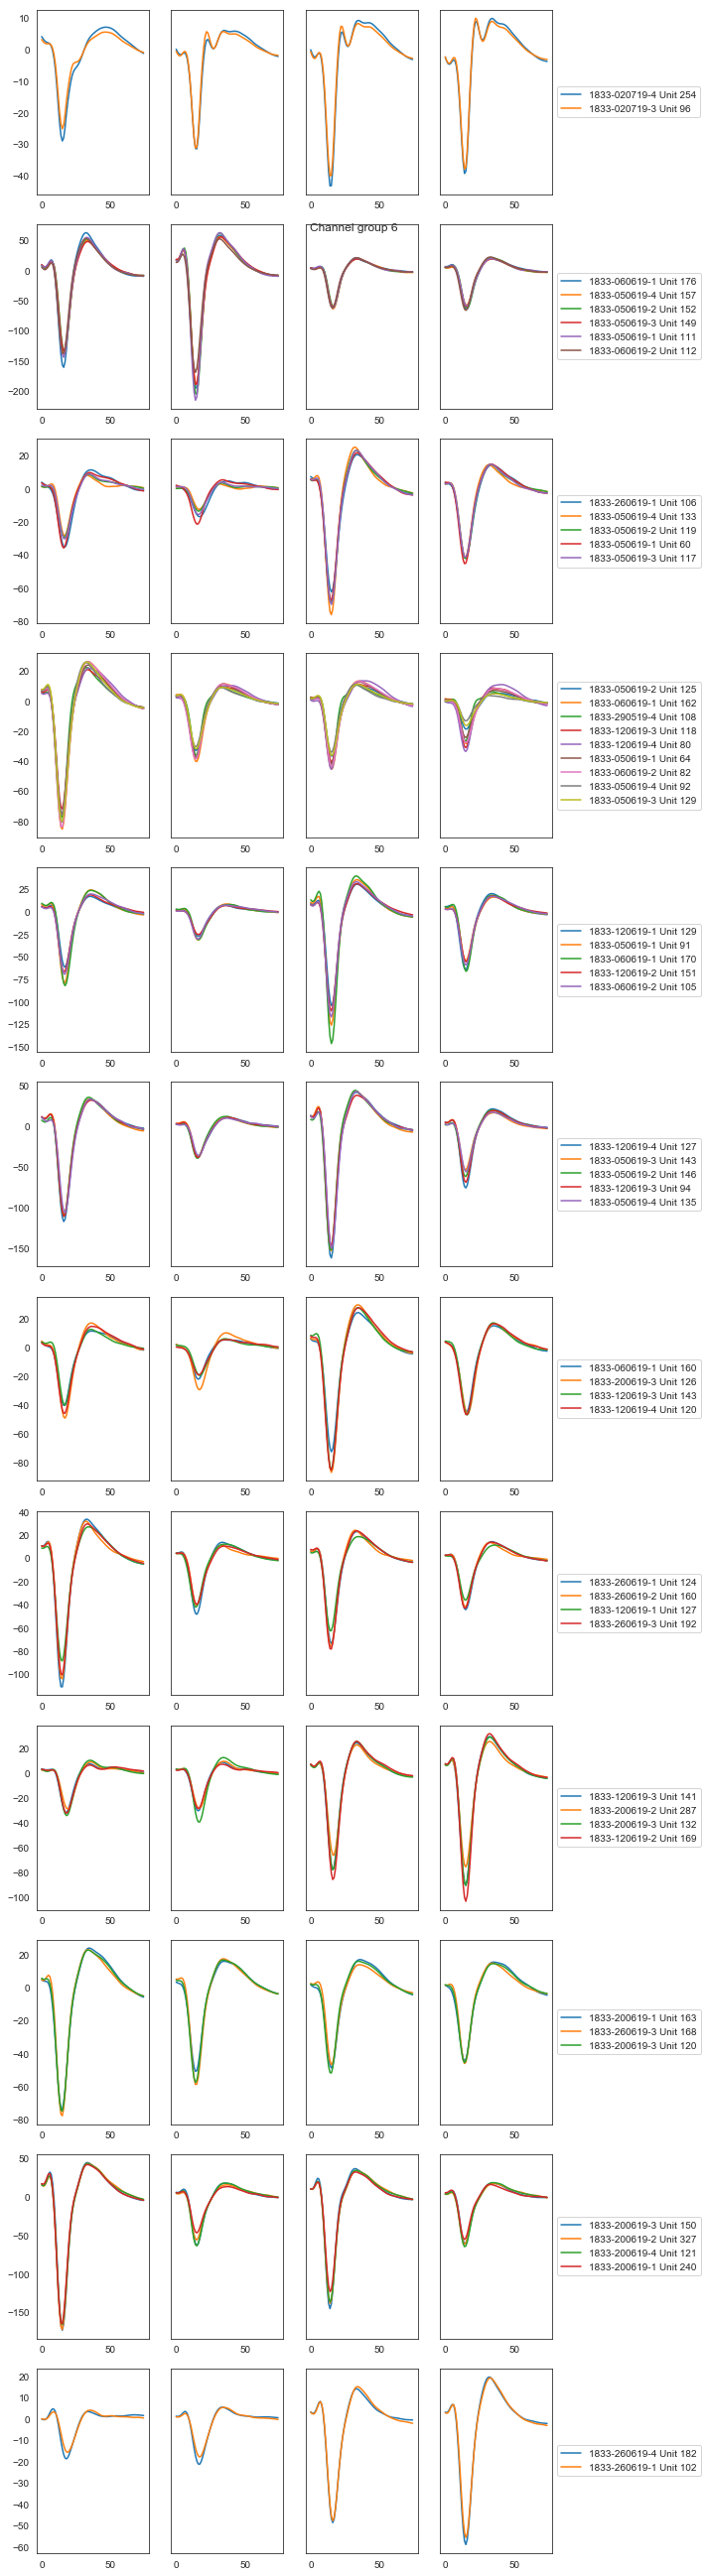

In [16]:
unit_comp.remove_edges_with_duplicate_actions()
unit_comp.identify_units()
unit_comp.plot_matches('template', chan_group=6, step_color=False)
plt.tight_layout()

# Store uniqe unit ids to csv

In [44]:
max_dissimilarity = .05
max_depth_delta = 100
id_nums = {}
num = 0
for entity, values in sessions.groupby('entity'):
    data_path = output / f'{entity}-graphs'
    unit_matching = TrackMultipleSessions(
        actions, values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.load_graphs()
    # cutoff large dissimilarities
    unit_matching.remove_edges_above_threshold('weight', max_dissimilarity)
    unit_matching.remove_edges_above_threshold('depth_delta', max_depth_delta)
    unit_matching.remove_edges_with_duplicate_actions()
    unit_matching.identify_units()
    units = []
    for ch, group in unit_matching.identified_units.items():
        for unit_id, val in group.items():
            for action_id, orig_unit_ids in val['original_unit_ids'].items():
                if unit_id not in id_nums:
                    id_nums[unit_id] = num
                    num += 1
                units.extend([
                    {
                        'unit_name': name, 
                        'unit_idnum': id_nums[unit_id],
                        'unit_id': unit_id, 
                        'action': action_id,
                        'channel_group': ch,
                        'max_dissimilarity': max_dissimilarity,
                        'max_depth_delta': max_depth_delta
                    } 
                    for name in orig_unit_ids])
    units = pd.DataFrame(units)
    units = units[~units.action.isin(skip_actions)]
    units.to_csv(output / f'{entity}-units.csv', index=False)

In [45]:
unique_units = pd.concat([
    pd.read_csv(p) 
    for p in output.iterdir() 
    if p.name.endswith('-units.csv')])

In [ ]:
# remove 1834-010319-3 unit 72

In [46]:
unique_units.to_csv(output / 'units.csv', index=False)

# Store results in Expipe action

In [47]:
identify_neurons.data['sessions'] = 'sessions.csv'
identify_neurons.data['units'] = 'units.csv'

In [48]:
copy_tree(output, str(identify_neurons.data_path()))

['/media/storage/expipe/septum-mec/actions/identify-neurons/data/1834-units.csv',
 '/media/storage/expipe/septum-mec/actions/identify-neurons/data/all_non_identified_units.csv',
 '/media/storage/expipe/septum-mec/actions/identify-neurons/data/1834-graphs/graph-group-7.yaml',
 '/media/storage/expipe/septum-mec/actions/identify-neurons/data/1834-graphs/graph-group-0.yaml',
 '/media/storage/expipe/septum-mec/actions/identify-neurons/data/1834-graphs/graph-group-6.yaml',
 '/media/storage/expipe/septum-mec/actions/identify-neurons/data/1834-graphs/graph-group-1.yaml',
 '/media/storage/expipe/septum-mec/actions/identify-neurons/data/1834-graphs/graph-group-2.yaml',
 '/media/storage/expipe/septum-mec/actions/identify-neurons/data/1834-graphs/graph-group-5.yaml',
 '/media/storage/expipe/septum-mec/actions/identify-neurons/data/1834-graphs/graph-group-3.yaml',
 '/media/storage/expipe/septum-mec/actions/identify-neurons/data/1834-graphs/graph-group-4.yaml',
 '/media/storage/expipe/septum-mec/act

In [96]:
store_notebook(
    identify_neurons, "00-identify-neurons.ipynb")